<a href="https://colab.research.google.com/github/RGivisiez/Adv_ML/blob/clean/XGboost_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from itertools import product

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [2]:
path = '~/Git_repo/Adv_ML/data'

# Loading data

In [24]:
train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

#print('Treino \n', train.head(), '\n')
#print('Itens \n', items.head(), '\n')
#print('Itens Cat \n', items_cat.head(), '\n')
#print('Shops \n', shops.head(), '\n')

In [25]:
print('Teste \n', test.tail() )

Teste 
         shop_id  item_id
ID                      
214195       45    18454
214196       45    16188
214197       45    15757
214198       45    19648
214199       45      969


# Creating new features

In [26]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis='columns', inplace=True)
#shops.head()

In [27]:
items_cat['split'] = items_cat['item_category_name'].str.split('-')
items_cat['type'] = items_cat['split'].map(lambda x: x[0].strip())
items_cat['type_code'] = LabelEncoder().fit_transform(items_cat['type'])

items_cat['subtype'] = items_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_cat['subtype_code'] = LabelEncoder().fit_transform(items_cat['subtype'])

items_cat.drop(['item_category_name', 'split', 'type', 'subtype'], axis='columns', inplace=True)
#items_cat.head()

In [28]:
items.drop(['item_name'], axis=1, inplace=True)
#items.head()

In [29]:
train.drop(['date'], axis='columns', inplace=True)
#train.head()

In [30]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

# Train_full é só pra fazer EDA

In [ ]:
train_full = pd.merge(train, shops, on='shop_id', how='left')
train_full = pd.merge(train_full, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
#train_full.head()

In [ ]:
# Liner correlation between features.
correlation = train_full.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True)
plt.show()

In [ ]:
print('Test:')
print('- Número de itens únicos:', test['item_id'].nunique())
print('- Número de shoppings únicos:', test['shop_id'].nunique())
print('\n Train_full:')
print('- Número de itens únicos:', train_full['item_id'].nunique())
print('- Número de shoppings únicos:', train_full['shop_id'].nunique())

In [ ]:
train_full.describe()

In [ ]:
test.describe()

In [ ]:
plt.hist(train_full['item_price'], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()

In [ ]:
plt.hist(train_full['item_price'][train_full.item_price < 8000], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()

In [ ]:
x = train_full['item_price'][train_full.item_price < 8000].values
x = np.log(np.abs(x))
plt.hist(x, bins = 30)
plt.title('Hist - item_price')
plt.xlabel('Log(Item Price)')
plt.show()

In [ ]:
train_full = train_full[train_full.item_price < 100000]
train_full = train_full[train_full.item_cnt_day < 1001]

In [ ]:
train_full.describe()

# Faz alterações no train e test

In [11]:
# Idk with this is true
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [12]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1001]

In [ ]:
# Colocar o item_price não faz sentido se for usar 
# medidas por mês.

#train.drop(['item_price'], axis=1, inplace=True)

# Months features

In [32]:
df_month = train.groupby(by=['date_block_num', 'shop_id', 'item_id'], axis='index').sum()
df_month.rename(columns={'item_cnt_day':'item_cnt_month', 'revenue':'revenue_month'}, inplace=True)
df_month.reset_index(inplace=True)
#df_month.head()

# Train and test more equals (Opção I)

In [31]:
n_months = train['date_block_num'].nunique()
aux = []
for i in range(n_months):
    df = train[train.date_block_num == i]
    shop_uniq, item_uniq = df.shop_id.unique(), df.item_id.unique()

    a = list(product([i], shop_uniq, item_uniq))
    a = np.array(a)
    aux.append(a)
aux = pd.DataFrame(np.vstack(aux), columns=['date_block_num', 'shop_id', 'item_id'])
aux.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [33]:
df_month = pd.merge(aux, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del aux

# Train and test more equals (Opção II)

In [ ]:
df_month = pd.merge(test, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

-----------------

In [34]:
df_month['item_cnt_month'] = df_month['item_cnt_month'].clip(0, 20)

# Adiciona o teste ao treino

In [17]:
test['date_block_num'] = 34
#test.head()

In [21]:
df_month = pd.concat([df_month, test], ignore_index=True, sort=False, keys=['date_block_num', 'shop_id', 'item_id']).fillna(0)
#df_month.tail()

In [35]:
df_month = pd.merge(df_month, shops, on=['shop_id'], how='left')
df_month = pd.merge(df_month, items, on=['item_id'], how='left')
df_month = pd.merge(df_month, items_cat, on=['item_category_id'], how='left')

In [42]:
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0,0.0,29,40,11,4
1,0,0,27,0.0,0,0.0,29,19,5,10
2,0,0,28,0.0,0,0.0,29,30,8,55
3,0,0,29,0.0,0,0.0,29,23,5,16
4,0,0,32,884.0,6,1326.0,29,40,11,4


In [38]:
df_month = df_month.fillna(0)

In [39]:
df_month['date_block_num'] = df_month['date_block_num'].astype('int8')
df_month['shop_id'] = df_month['shop_id'].astype('int8')
df_month['item_id'] = df_month['item_id'].astype('int16')
df_month['item_cnt_month'] = df_month['item_cnt_month'].astype('int8')
df_month['item_category_id'] = df_month['item_category_id'].astype('int8')
df_month['revenue_month'] = df_month['revenue_month'].astype('float32')
df_month['city_code'] = df_month['city_code'].astype('int8')
df_month['type_code'] = df_month['type_code'].astype('int8')
df_month['subtype_code'] = df_month['subtype_code'].astype('int8')

In [40]:
df_month.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,1.497334e+01,3.118720e+01,1.130926e+04,2.396414e+02,2.982399e-01,3.114325e+02,1.530064e+01,4.491731e+01,1.107079e+01,1.801534e+01
std,9.495618e+00,1.734959e+01,6.209978e+03,2.263861e+03,1.222373e+00,5.928663e+03,8.015697e+00,1.510627e+01,2.847764e+00,2.012309e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.378700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.976000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,3.700000e+01,1.100000e+01,2.000000e+00
50%,1.400000e+01,3.000000e+01,1.139100e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,4.000000e+00
75%,2.300000e+01,4.600000e+01,1.660500e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01,5.500000e+01,1.300000e+01,3.200000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,6.719300e+05,2.000000e+01,6.264230e+06,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01


# PCA

-https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

In [ ]:
col = ['city_code', 'item_category_id', 'type_code']

In [ ]:
scaler = StandardScaler().fit(df_month[col]) # salva a média e std de cada coluna, para poder ser aplicado no set de treino.
X = scaler.transform(df_month[col])
print('\nMean:', scaler.mean_, '\n\nStd:', scaler.scale_)

In [ ]:
#@title Dataframe centrado em zero com variância 1.
pd.DataFrame(X, columns=df_month.columns).describe()

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [ ]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.ylabel('Importance')
plt.xlabel('Component number')
plt.show()

In [ ]:
df_month.drop(col, axis=1, inplace=True)

In [ ]:
df_month['PCA1'] = principalDf[0]
df_month['PCA2'] = principalDf[1]

# Lagged features

In [26]:
df_lag3 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag3.rename(columns={'item_cnt_month':'lag3_item_cnt_month', 'revenue_month':'lag3_revenue_month'}, inplace=True)
df_lag3['date_block_num'] += 3
df_month = pd.merge(df_month, df_lag3, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del df_lag3

In [27]:
df_lag6 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag6.rename(columns={'item_cnt_month':'lag6_item_cnt_month', 'revenue_month':'lag6_revenue_month'}, inplace=True)
df_lag6['date_block_num'] += 6
df_month = pd.merge(df_month, df_lag6, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del df_lag6

In [28]:
df_lag9 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag9.rename(columns={'item_cnt_month':'lag9_item_cnt_month', 'revenue_month':'lag9_revenue_month'}, inplace=True)
df_lag9['date_block_num'] += 9
df_month = pd.merge(df_month, df_lag9, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del df_lag9

In [29]:
df_lag12 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag12.rename(columns={'item_cnt_month':'lag12_item_cnt_month', 'revenue_month':'lag12_revenue_month'}, inplace=True)
df_lag12['date_block_num'] += 12
df_month = pd.merge(df_month, df_lag12, on=['date_block_num', 'shop_id', 'item_id'], how='left')
del df_lag12

In [41]:
df_month = df_month.fillna(0)
df_month['lag3_item_cnt_month'] = df_month['lag3_item_cnt_month'].astype('int8')
df_month['lag6_item_cnt_month'] = df_month['lag6_item_cnt_month'].astype('int8')
df_month['lag9_item_cnt_month'] = df_month['lag9_item_cnt_month'].astype('int8')
df_month['lag12_item_cnt_month'] = df_month['lag12_item_cnt_month'].astype('int8')

df_month['lag3_revenue_month'] = df_month['lag3_revenue_month'].astype('float32')
df_month['lag6_revenue_month'] = df_month['lag6_revenue_month'].astype('float32')
df_month['lag9_revenue_month'] = df_month['lag9_revenue_month'].astype('float32')
df_month['lag12_revenue_month'] = df_month['lag12_revenue_month'].astype('float32')

In [41]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913850 entries, 0 to 10913849
Data columns (total 10 columns):
date_block_num      int8
shop_id             int8
item_id             int16
item_price          float64
item_cnt_month      int8
revenue_month       float32
city_code           int8
item_category_id    int8
type_code           int8
subtype_code        int8
dtypes: float32(1), float64(1), int16(1), int8(7)
memory usage: 301.8 MB


In [43]:
df_month.describe()

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code,lag3_item_cnt_month,lag3_revenue_month,lag6_item_cnt_month,lag6_revenue_month,lag9_item_cnt_month,lag9_revenue_month,lag12_item_cnt_month,lag12_revenue_month
count,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07,1.112805e+07
mean,1.533958e+01,3.138372e+01,1.130368e+04,2.924992e-01,3.054377e+02,1.530356e+01,4.494411e+01,1.107024e+01,1.810714e+01,2.604554e-01,2.692053e+02,2.239191e-01,2.328118e+02,1.854716e-01,1.881902e+02,1.444080e-01,1.445313e+02
std,9.760396e+00,1.730666e+01,6.210930e+03,1.211245e+00,5.871481e+03,8.018806e+00,1.514009e+01,2.854891e+00,2.015450e+01,1.161139e+00,5.492700e+03,1.099720e+00,5.298132e+03,1.018883e+00,4.807396e+03,9.196087e-01,4.616878e+03
min,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,-3.378700e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.349000e+04,0.000000e+00,-3.349000e+04,0.000000e+00,-1.899000e+04,0.000000e+00,-1.899000e+04
25%,7.000000e+00,1.600000e+01,5.947000e+03,0.000000e+00,0.000000e+00,1.000000e+01,3.700000e+01,1.100000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,3.100000e+01,1.138800e+04,0.000000e+00,0.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.300000e+01,4.700000e+01,1.659200e+04,0.000000e+00,0.000000e+00,2.200000e+01,5.500000e+01,1.300000e+01,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.400000e+01,5.900000e+01,2.216900e+04,2.000000e+01,6.264230e+06,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01,2.000000e+01,6.264230e+06,2.000000e+01,6.264230e+06,2.000000e+01,6.264230e+06,2.000000e+01,6.264230e+06


In [44]:
df_month.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code,lag3_item_cnt_month,lag3_revenue_month,lag6_item_cnt_month,lag6_revenue_month,lag9_item_cnt_month,lag9_revenue_month,lag12_item_cnt_month,lag12_revenue_month
0,0,2,19,0,0.0,0,40,11,4,0,0.0,0,0.0,0,0.0,0,0.0
1,0,2,27,1,2499.0,0,19,5,10,0,0.0,0,0.0,0,0.0,0,0.0
2,0,2,28,0,0.0,0,30,8,55,0,0.0,0,0.0,0,0.0,0,0.0
3,0,2,29,0,0.0,0,23,5,16,0,0.0,0,0.0,0,0.0,0,0.0
4,0,2,32,0,0.0,0,40,11,4,0,0.0,0,0.0,0,0.0,0,0.0


In [48]:
col2 = df_month.columns[4:]

In [49]:
scaler = StandardScaler().fit(df_month[col2])
X = scaler.transform(df_month[col2])
df_month[col2] = pd.DataFrame(X, columns=col2)
df_month.head()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int8, float32 were all converted to float64 by StandardScaler.
  


,date_block_num,shop_id,item_id,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code,lag3_item_cnt_month,lag3_revenue_month,lag6_item_cnt_month,lag6_revenue_month,lag9_item_cnt_month,lag9_revenue_month,lag12_item_cnt_month,lag12_revenue_month
0,0,2,19,0,-0.052021,-1.908459,-0.326557,-0.024604,-0.699950,-0.22431,-0.049011,-0.203615,-0.043942,-0.182034,-0.039146,-0.157032,-0.031305
1,0,2,27,1,0.373596,-1.908459,-1.713604,-2.126261,-0.402250,-0.22431,-0.049011,-0.203615,-0.043942,-0.182034,-0.039146,-0.157032,-0.031305
2,0,2,28,0,-0.052021,-1.908459,-0.987056,-1.075432,1.830503,-0.22431,-0.049011,-0.203615,-0.043942,-0.182034,-0.039146,-0.157032,-0.031305
3,0,2,29,0,-0.052021,-1.908459,-1.449404,-2.126261,-0.104549,-0.22431,-0.049011,-0.203615,-0.043942,-0.182034,-0.039146,-0.157032,-0.031305
4,0,2,32,0,-0.052021,-1.908459,-0.326557,-0.024604,-0.699950,-0.22431,-0.049011,-0.203615,-0.043942,-0.182034,-0.039146,-0.157032,-0.031305


In [52]:
df_month['revenue_month'] = df_month['revenue_month'].astype('float32')
df_month['item_category_id'] = df_month['item_category_id'].astype('float32')
df_month['city_code'] = df_month['city_code'].astype('float32')
df_month['type_code'] = df_month['type_code'].astype('float32')
df_month['subtype_code'] = df_month['subtype_code'].astype('float32')

df_month['lag3_item_cnt_month'] = df_month['lag3_item_cnt_month'].astype('float32')
df_month['lag6_item_cnt_month'] = df_month['lag6_item_cnt_month'].astype('float32')
df_month['lag9_item_cnt_month'] = df_month['lag9_item_cnt_month'].astype('float32')
df_month['lag12_item_cnt_month'] = df_month['lag12_item_cnt_month'].astype('float32')

df_month['lag3_revenue_month'] = df_month['lag3_revenue_month'].astype('float32')
df_month['lag6_revenue_month'] = df_month['lag6_revenue_month'].astype('float32')
df_month['lag9_revenue_month'] = df_month['lag9_revenue_month'].astype('float32')
df_month['lag12_revenue_month'] = df_month['lag12_revenue_month'].astype('float32')
df_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 17 columns):
date_block_num          int8
shop_id                 int8
item_id                 int16
item_cnt_month          int8
revenue_month           float32
city_code               float32
item_category_id        float32
type_code               float32
subtype_code            float32
lag3_item_cnt_month     float32
lag3_revenue_month      float32
lag6_item_cnt_month     float32
lag6_revenue_month      float32
lag9_item_cnt_month     float32
lag9_revenue_month      float32
lag12_item_cnt_month    float32
lag12_revenue_month     float32
dtypes: float32(13), int16(1), int8(3)
memory usage: 689.8 MB


# XGboost

In [53]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8,
    #nthread = 6,
    n_jobs = 6,
    seed = 42,
    eta=0.3)

X_train = df_month[df_month.date_block_num < 33].drop(['item_cnt_month'], axis='columns')
Y_train = df_month[df_month.date_block_num < 33]['item_cnt_month']

X_valid = df_month[df_month.date_block_num == 33].drop(['item_cnt_month'], axis='columns')
Y_valid = df_month[df_month.date_block_num == 33]['item_cnt_month']

X_test = df_month[df_month.date_block_num == 34].drop(['item_cnt_month'], axis=1)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

[20:02:22] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.15318	validation_1-rmse:1.08203
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.0746	validation_1-rmse:1.0141
[2]	validation_0-rmse:1.0061	validation_1-rmse:0.954462
[3]	validation_0-rmse:0.947151	validation_1-rmse:0.906358
[4]	validation_0-rmse:0.931037	validation_1-rmse:0.891276
[5]	validation_0-rmse:0.881012	validation_1-rmse:0.851407
[6]	validation_0-rmse:0.837495	validation_1-rmse:0.811309
[7]	validation_0-rmse:0.829062	validation_1-rmse:0.802353
[8]	validation_0-rmse:0.792071	validation_1-rmse:0.771168
[9]	validation_0-rmse:0.784024	validation_1-rmse:0.764642
[10]	validation_0-rmse:0.752936	validation_1-rmse:0.741211
[11]	validation_0-rmse:0.726535	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=300, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, nthreads=6,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.8)

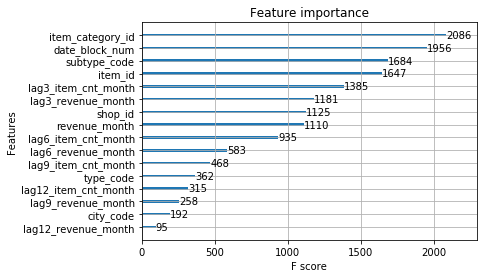

In [54]:
xgb.plot_importance(model, importance_type='weight')
plt.show()

In [55]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [56]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# RNN

- Samples: One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps: One time step is one point of observation in the sample.
- Features: One feature is one observation at a time step.

In [43]:
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,revenue_month,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0,0.0,29,40,11,4
1,0,0,27,0.0,0,0.0,29,19,5,10
2,0,0,28,0.0,0,0.0,29,30,8,55
3,0,0,29,0.0,0,0.0,29,23,5,16
4,0,0,32,884.0,6,1326.0,29,40,11,4


In [611]:
X_train = df_month.pivot_table(index=['shop_id', 'item_id'],
                               columns=['date_block_num'], values=['item_cnt_month'])
X_train.head()

item_cnt_month                                      ...      \
date_block_num              0    1   2   3   4   5   6   7   8   9  ...  24   
shop_id item_id                                                     ...       
0       12                 NaN  0.0 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   
        19                 0.0  NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   
        27                 0.0  0.0 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   
        28                 0.0  0.0 NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   
        29                 0.0  NaN NaN NaN NaN NaN NaN NaN NaN NaN ... NaN   

                                                     
date_block_num   25  26  27  28  29  30  31  32  33  
shop_id item_id                                      
0       12      NaN NaN NaN NaN NaN NaN NaN NaN NaN  
        19      NaN NaN NaN NaN NaN NaN NaN NaN NaN  
        27      NaN NaN NaN NaN NaN NaN NaN NaN NaN  
        28      NaN NaN NaN NaN NaN NaN NaN NaN NaN  
        29      NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 34 columns]

In [612]:
X_train.columns = X_train.columns.droplevel(0)

In [613]:
X_train.columns = [str(x) for x in range(34)]

In [614]:
X_train.fillna(0, inplace=True)

In [615]:
X_train = X_train.reset_index()
Y_train = X_train['33']
X_train.drop('33', axis=1, inplace=True)

In [616]:
def adding_features(df, feature_id_start, features_id_end, time_step):

    cont = time_step

    for name in df.columns[feature_id_start:feature_id_end]:
        for t in range(time_step):
            df[str(cont)] = df[name]
            cont +=1
    return df

In [617]:
X_train = adding_features(X_train, 0, 2, 33)

In [618]:
X_train.drop(['shop_id', 'item_id'], axis=1, inplace=True)

In [619]:
n_samples = X_train.shape[0]

time_step = 33
features = 3

print(n_samples, time_step, features)

1136205 33 3


In [677]:
X_train.head(6)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,12,12,12,12,12,12,12,12,12
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19,19,19,19,19,19,19,19,19,19
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27,27,27,27,27,27,27,27,27,27
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,28,28,28,28,28,28,28,28,28
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29,29,29,29,29,29,29,29,29,29
5,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30,30,30,30,30,30,30,30,30,30


In [675]:
X_train.head(6).T

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0


In [682]:
X_train = X_train.values.reshape((n_samples, time_step, features))

In [649]:
X = X.reshape((n_samples, time_step, features))

In [683]:
X[0,:,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  3.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
         0., 20.,  0.,  1.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [589]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(time_step, features)))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [590]:
model.fit(X_train, Y_train, batch_size = 4096, epochs = 10)

ValueError: Error when checking input: expected lstm_2_input to have shape (33, 3) but got array with shape (3, 33)